В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического 
врачебного осмотра. Датасет сформирован и 100.000 реальных клинических анализов, и в нём используются признаки,
которые можно разбить на 3 группы:
    
Объективные признаки:

     - Возраст
     - Рост
     - Вес
     - Пол

Результаты измерения:

     - Артериальное давление верхнее и нижнее
     - Холестерин
     - Глюкоза

Субъективные признаки:

     - Курение
     - Употребление Алкоголя
     - Физическая активность

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма,
    выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.
 
Последняя группа признаков не имеет однозначной интерпретации и более того, собрана со слов самого больного.
Поэтому, для части данных в тестовой выборке мы специально исключили эти параметры. Участникам придется либо
предсказать их самостоятельно для некоторых случаев, либо вовсе игнорировать.

In [83]:
import os
import pandas as pd

In [84]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy

import seaborn as sns
sns.set(style="white", color_codes=True)

%matplotlib inline

In [85]:
data = pd.read_csv('data/train.csv',sep=";")

In [32]:
#пропуски в данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [33]:
data['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

In [86]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Можно заметить, что имеют место некорректные значения. Работу по коррекции значений можно проводить исходя из общих соображений,
также привлекать автоматизированные методы. Выбор тех или иных подходов может быть обусловен условием задачи. Иногда можно просто
избавиться от неправильных значений без потерь.

# Таблицы


In [35]:
#среднее значение cardio зависит от уровня холестерина
data.groupby(['gender','cholesterol'])['cardio'].aggregate('mean').unstack()

cholesterol,1,2,3
gender,,,
1,0.434555,0.584726,0.770920
2,0.450013,0.637635,0.753288


Между мужчинами и женщинам разницы нет, но зато есть разница у тех, кого холестерин в норме, выше нормы и много выше нормы

In [36]:
#среднее значение cardio зависит от уровня сахара
data.groupby(['gender','gluc'])['cardio'].aggregate('mean').unstack()

gluc,1,2,3
gender,,,
1,0.475995,0.581089,0.636563
2,0.489004,0.616122,0.590640


Казалось бы логично предположить, что среди людей с сахаром много выше нормы, будет больше больных СС3, 
но это верно только для мужчин

In [37]:
#курение
data.groupby(['smoke'])['cardio'].aggregate('mean')

smoke
0    0.502107
1    0.474793
Name: cardio, dtype: float64

In [38]:
#алкоголь
data.groupby(['alco'])['cardio'].aggregate('mean')

alco
0    0.500574
1    0.484325
Name: cardio, dtype: float64

Люди, которые курят и пьют в среднем имеют меньше проблем с сердцем???

In [ ]:
data.corr()

# Потенциальные проблемы

## нижние и верхнее давление

Text(0, 0.5, 'al_hi')

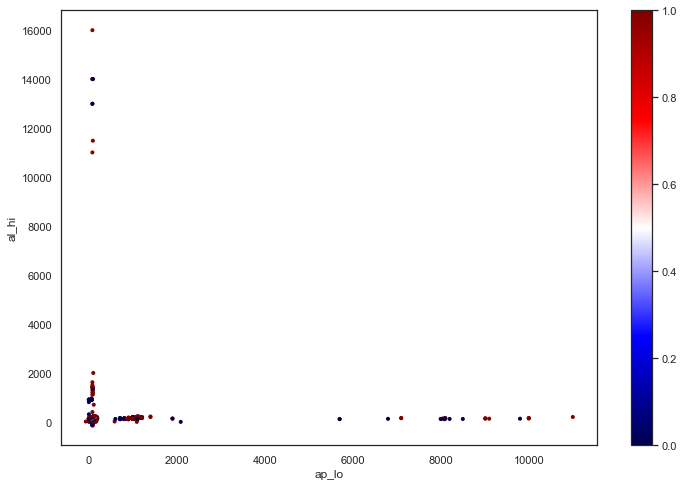

In [87]:
#отобразим верхнее и нижнее давление
plt.figure(figsize=(12,8))
plt.scatter(data.ap_lo,data.ap_hi,s=9,c=data.cardio,cmap='seismic')
plt.colorbar()
plt.plot([50,200],[50,200],'--',linewidth=0.8)
plt.xlabel('ap_lo')
plt.ylabel('al_hi')

## вес и рост

Text(0, 0.5, 'height')

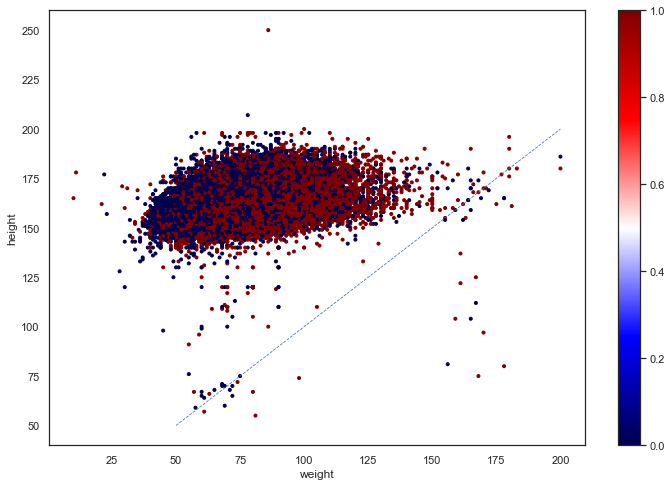

In [88]:
#
plt.figure(figsize=(12,8))
plt.scatter(data.weight,data.height,s=9,c=data.cardio,cmap='seismic')
plt.colorbar()
plt.plot([50,200],[50,200],'--',linewidth=0.8)
plt.xlabel('weight')
plt.ylabel('height')

Что сразу бросается в глаза? Есть ли на графике нереалистичные данные? Избавиться от наблюдения или принять его верным?

# Спосбо нахождения аномалий

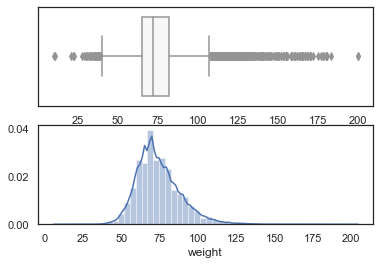

In [89]:
#диаграмма размаха
f, axes = plt.subplots(2,1)

sns.boxplot(data.weight, palette="PRGn",ax=axes[0])
sns.distplot(data.weight, ax=axes[1])

Диаграммы размаха («ящик с усами») (Box and Whisker Plot или Box Plot) – это удобный способ визуального представления групп числовых данных через квартили. Прямые линии, исходящие из ящика, называются «усами» и используются для обозначения степени разброса (дисперсии) за пределами верхнего и нижнего квартилей.

In [90]:
#Image(filename='800px-Boxplot_vs_PDF.svg.png')
![](800px-Boxplot_vs_PDF.svg.png)

"[]" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


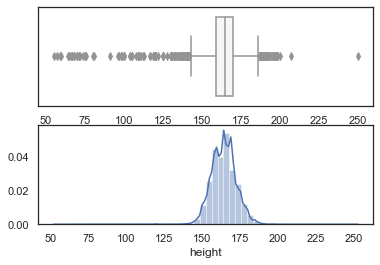

In [91]:
f, axes = plt.subplots(2,1)

sns.boxplot(data.height, palette="PRGn",ax=axes[0])
sns.distplot(data.height, ax=axes[1])

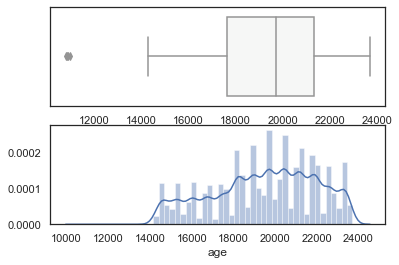

In [92]:
f, axes = plt.subplots(2,1)

sns.boxplot(data.age, palette="PRGn",ax=axes[0])
sns.distplot(data.age, ax=axes[1])

In [ ]:
#иллюстация для диаграммы размах

In [93]:
d=[180,147,200,150,130,165]


In [27]:
sorted(d)

[130, 147, 150, 165, 180, 200]

In [94]:
numpy.mean(d)

162.0

In [95]:
numpy.median(d)

157.5

In [96]:
d=[180,147,200,150,130,165,300]

In [97]:
numpy.mean(d)

181.71428571428572

In [98]:
numpy.median(d)

165.0

# произведем очистку данных

In [99]:
mask = (data.ap_hi==1)&(data.ap_lo>100)
data.loc[mask,'ap_hi']=(data.loc[mask,'ap_hi']*100+(data.loc[mask,'ap_lo']//100))
data.loc[mask,'ap_lo'] = (data.loc[mask,'ap_lo'].mod(100)//10)*10
data.loc[data.ap_hi==14900,'ap_hi']=140
data.loc[data.ap_hi>4000,'ap_hi']//=100
mask = (data.ap_lo==0)&(data.ap_hi>=300)
data.loc[mask,'ap_hi'],data.loc[mask,'ap_lo']=data.loc[mask,'ap_hi']//10,data.loc[mask,'ap_hi'].mod(10)*10
data.loc[data.ap_hi.isin([400,401]),'ap_hi']=140
data.loc[data.ap_hi==701,'ap_hi']=170
data.loc[data.ap_hi==1420,'ap_hi']=140
data.loc[data.ap_hi==1620,'ap_hi']=160
data.loc[data.ap_hi.isin([1130,1110]),'ap_hi']=110
data.loc[data.ap_hi==960,'ap_hi']=90
data.loc[data.ap_hi==300,'ap_hi']=10
data.loc[data.ap_hi>=240,'ap_hi']=(data.loc[data.ap_hi>=240,'ap_hi']//100)*10

data.loc[data.ap_lo==4100,'ap_lo']=140
data.loc[data.ap_lo==10000,'ap_lo']=100
data.loc[data.ap_lo==5700,'ap_lo']=75
data.loc[data.ap_lo==6800,'ap_lo']=80
data.loc[data.ap_lo==4700,'ap_lo']=70
data.loc[data.ap_lo==1100,'ap_lo']=110

data.loc[data.ap_lo>=4000,'ap_lo']=(data.loc[data.ap_lo>=4000,'ap_lo']//1000)*10
data.loc[data.ap_lo==1900,'ap_lo']=90
data.loc[data.ap_lo==1211,'ap_lo']=120
data.loc[data.ap_lo>=1200,'ap_lo']//=10
data.loc[data.ap_lo>=1100,'ap_lo']=(data.loc[data.ap_lo>=1100,'ap_lo']//100)*10
data.loc[data.ap_lo>=1000,'ap_lo']=100
data.loc[data.ap_lo==570,'ap_lo']=75
data.loc[data.ap_lo.isin([850,855]),'ap_lo']=85
data.loc[data.ap_lo>=300,'ap_lo']=(data.loc[data.ap_lo>=300,'ap_lo']//100)*10


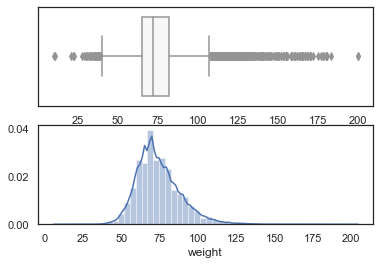

In [100]:
#диаграмма размаха
f, axes = plt.subplots(2,1)

sns.boxplot(data.weight, palette="PRGn",ax=axes[0])
sns.distplot(data.weight, ax=axes[1])

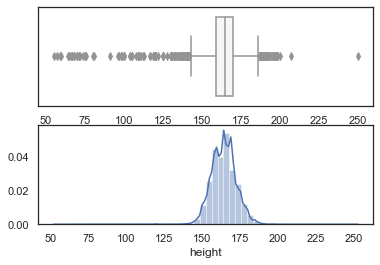

In [101]:
f, axes = plt.subplots(2,1)

sns.boxplot(data.height, palette="PRGn",ax=axes[0])
sns.distplot(data.height, ax=axes[1])

In [ ]:
data.corr()

In [ ]:
sns.pairplot(data[['age','height','weight']],size=3)

In [ ]:
data.describe()

# посмотрим на распределение признаков в наборе данных

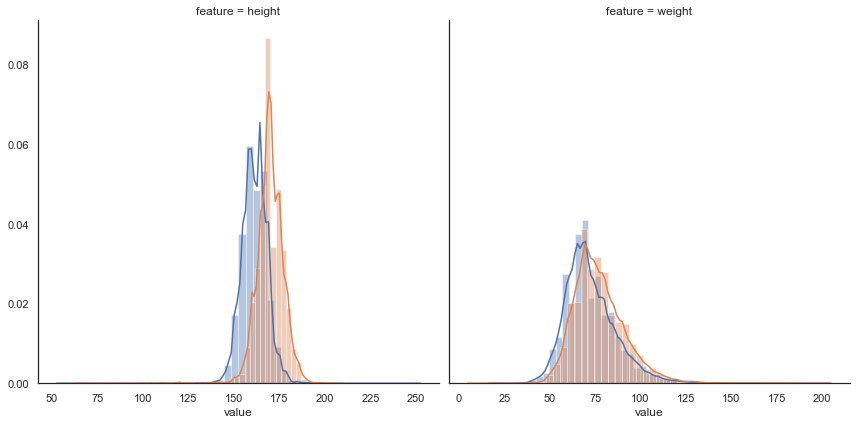

In [102]:
#рост,вес,возраст
data_long = pd.melt(data[['height','weight','gender']],"gender",var_name="feature")
g= sns.FacetGrid(data_long, col="feature",hue="gender",col_wrap=2,sharex=False,size=6,legend_out=True)
g.map(sns.distplot,"value")

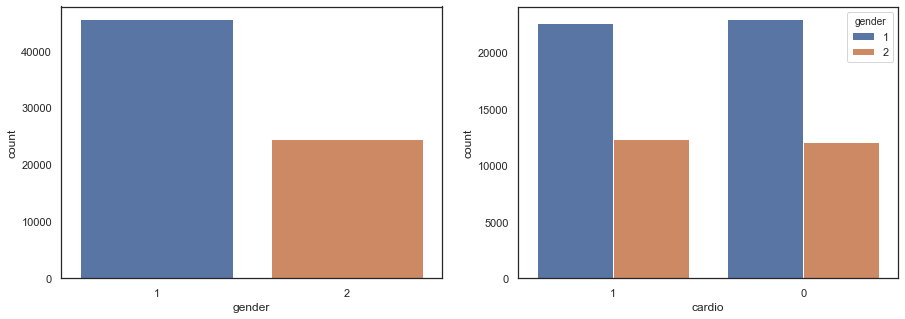

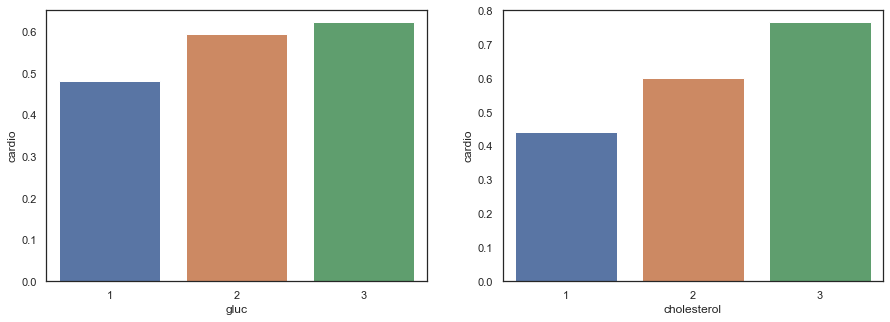

In [103]:
#сколько мужчин, женищн в соотношении cardio 1/0 у мужчин и женщин
fig, (axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
fig, (axis3,axis4)=plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='gender',data=data,ax=axis1)
sns.countplot(x='cardio',hue="gender",data=data,order=[1,0],ax=axis2)


data_gluc = data[["gluc","cardio"]].groupby(['gluc'],as_index=False).mean()
sns.barplot(x='gluc', y='cardio',data=data_gluc,order=[1,2,3],ax=axis3)

data_gluc = data[["cholesterol","cardio"]].groupby(["cholesterol"],as_index=False).mean()
sns.barplot(x='cholesterol',y='cardio',data=data_gluc,order=[1,2,3],ax=axis4)

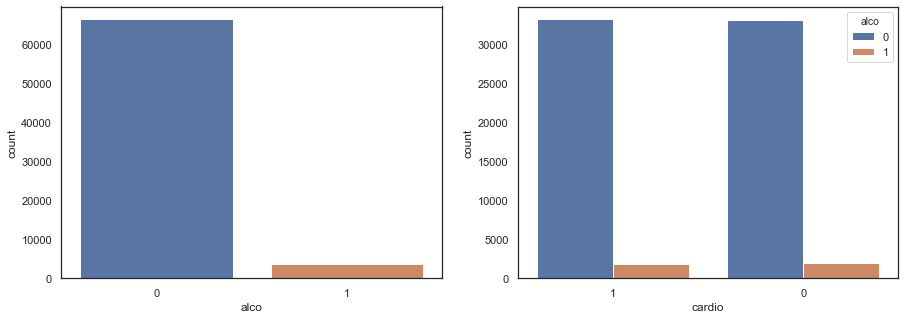

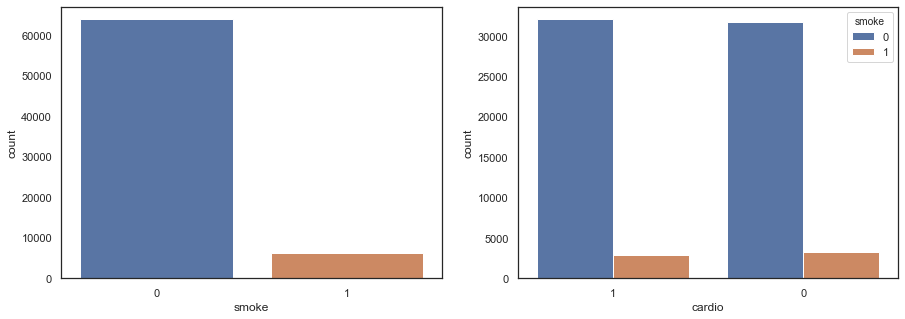

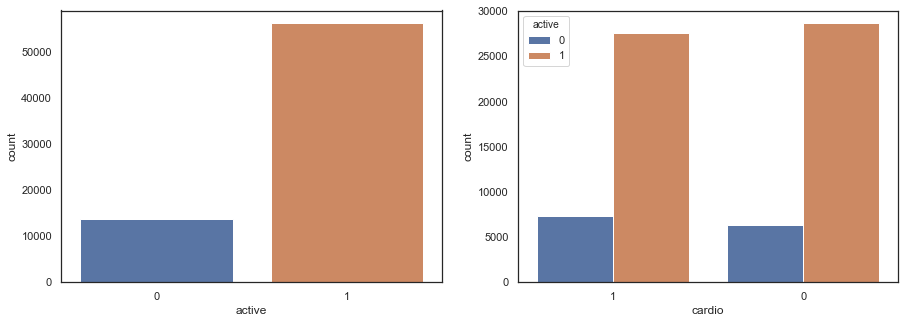

In [104]:
#сколько больных в зависимости от алкоголя
fig, (axis1,axis2)=plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='alco',data=data,ax= axis1)
sns.countplot(x='cardio',hue="alco",data=data,order=[1,0],ax=axis2)

#сколько больных в зависимости от курения
fig, (axis3,axis4)=plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='smoke',data=data,ax=axis3)
sns.countplot(x='cardio', hue="smoke",data=data,order=[1,0],ax=axis4)

#сколько занимаются спортом
fig, (axis5,axis6)=plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='active',data=data,ax=axis5)
sns.countplot(x='cardio',hue="active",data=data,order=[1,0],ax=axis6)

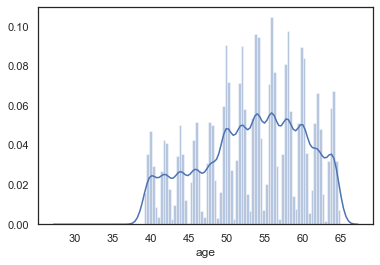

In [105]:
#посмортим на возраст, но сначал преобразуем его
data['age']=data['age']/365.25
sns.distplot(data['age'],label="Age",bins=100)

Text(0, 0.5, 'al_hi')

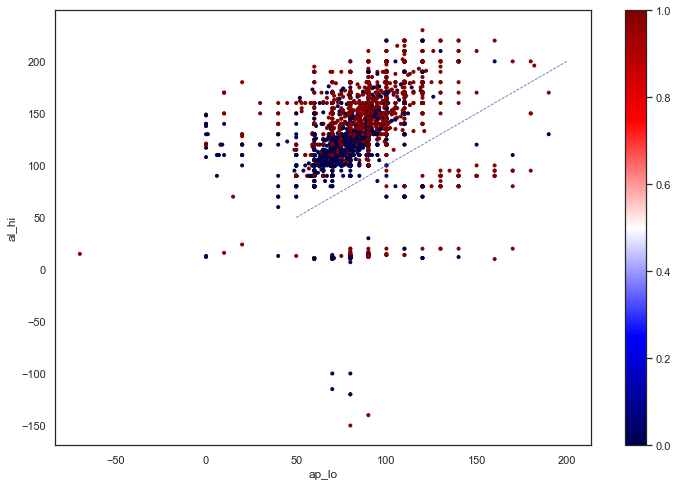

In [106]:
plt.figure(figsize=(12,8))
plt.scatter(data.ap_lo,data.ap_hi,s=9,c=data.cardio,cmap='seismic')
plt.colorbar()
plt.plot([50,200],[50,200],'--',linewidth=0.8)
plt.xlabel('ap_lo')
plt.ylabel('al_hi')

In [107]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.302850,1.349571,164.359229,74.205690,126.658171,81.600614,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,6.754967,0.476838,8.210126,14.395757,18.200047,10.130270,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,29.563313,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.361396,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,53.943874,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,58.390144,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,64.922656,2.000000,250.000000,200.000000,230.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000
